In [ ]:
#| default_exp ljubljana

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from pathlib import Path
from typing import Optional, Union

import h5py
import torch
from beartype import beartype

from diffpose.calibration import RigidTransform

# `Ljubljana`

In [ ]:
#| export
from diffdrr.utils import parse_intrinsic_matrix


@beartype
class LjubljanaDataset(torch.utils.data.Dataset):
    """
    Get X-ray projections and poses from specimens in the `Ljubljana` dataset.

    Given a specimen ID and projection index, returns the projection and the camera matrix for DiffDRR.
    """

    def __init__(
        self,
        view: str,  # "ap" or "lat" or "ap-max" or "lat-max"
        filename: Optional[Union[str, Path]] = None,  # Path to DeepFluoro h5 file
        preprocess: bool = True,  # Preprocess X-rays
    ):
        self.view = view
        self.preprocess = preprocess

        if filename is None:
            root = Path(__file__).parent.parent.absolute()
            filename = root / "data/ljubljana.h5"
        self.f = h5py.File(filename)

        self.flip_xz = RigidTransform(
            torch.tensor(
                [
                    [0.0, 0.0, -1.0],
                    [0.0, 1.0, 0.0],
                    [1.0, 0.0, 0.0],
                ]
            ),
            torch.zeros(3),
        )

    def __len__(self):
        return 10

    def __iter__(self):
        return iter(self[idx] for idx in range(len(self)))

    def __getitem__(self, idx):
        idx += 1
        extrinsic = self.f[f"subject{idx:02d}/proj-{self.view}/extrinsic"][:]
        extrinsic = torch.from_numpy(extrinsic)
        extrinsic = RigidTransform(extrinsic[..., :3, :3], extrinsic[:3, 3])

        intrinsic = self.f[f"subject{idx:02d}/proj-{self.view}/intrinsic"][:]
        intrinsic = torch.from_numpy(intrinsic)

        delx = self.f[f"subject{idx:02d}/proj-{self.view}/col-spacing"][()]
        dely = self.f[f"subject{idx:02d}/proj-{self.view}/row-spacing"][()]

        img = torch.from_numpy(self.f[f"subject{idx:02d}/proj-{self.view}/pixels"][:])
        if self.preprocess:
            img += 1
            img = img.max().log() - img.log()
        height, width = img.shape
        img = img.unsqueeze(0).unsqueeze(0)

        focal_len, x0, y0 = parse_intrinsic_matrix(
            intrinsic,
            height,
            width,
            dely,
            delx,
        )

        translate = RigidTransform(
            torch.eye(3),
            torch.tensor([-focal_len / 2, 0.0, 0.0]),
        )
        pose = translate.compose(self.flip_xz).compose(extrinsic.inverse())

        volume = self.f[f"subject{idx:02d}/volume/pixels"][:]
        spacing = self.f[f"subject{idx:02d}/volume/spacing"][:]

        isocenter_rot = torch.tensor([[torch.pi / 2, 0.0, -torch.pi / 2]])
        isocenter_xyz = torch.tensor(volume.shape) * spacing / 2
        isocenter_xyz = isocenter_xyz.unsqueeze(0)
        isocenter_pose = RigidTransform(
            isocenter_rot, isocenter_xyz, "euler_angles", "ZYX"
        )

        return (
            volume,
            spacing,
            focal_len,
            height,
            width,
            delx,
            dely,
            x0,
            y0,
            img,
            pose,
            isocenter_pose,
        )

## Distribution over camera poses

We sample the three rotational and three translational parameters of $\mathfrak{se}(3)$ from independent normal distributions defined with sufficient variance to capture wide perturbations from the isocenter.

In [ ]:
#| export
from diffpose.calibration import RigidTransform, convert


@beartype
def get_random_offset(view, batch_size: int, device) -> RigidTransform:
    if view == "ap":
        t1 = torch.distributions.Normal(-6, 30).sample((batch_size,))
        t2 = torch.distributions.Normal(175, 30).sample((batch_size,))
        t3 = torch.distributions.Normal(-5, 30).sample((batch_size,))
        r1 = torch.distributions.Normal(0, 0.1).sample((batch_size,))
        r2 = torch.distributions.Normal(0, 0.1).sample((batch_size,))
        r3 = torch.distributions.Normal(-0.15, 0.25).sample((batch_size,))
    elif view == "lat":
        t1 = torch.distributions.Normal(75, 30).sample((batch_size,))
        t2 = torch.distributions.Normal(-80, 30).sample((batch_size,))
        t3 = torch.distributions.Normal(-5, 30).sample((batch_size,))
        r1 = torch.distributions.Normal(0, 0.1).sample((batch_size,))
        r2 = torch.distributions.Normal(0, 0.05).sample((batch_size,))
        r3 = torch.distributions.Normal(1.55, 0.05).sample((batch_size,))
    else:
        raise ValueError(f"view must be 'ap' or 'lat', not '{view}'")

    log_R_vee = torch.stack([r1, r2, r3], dim=1).to(device)
    log_t_vee = torch.stack([t1, t2, t3], dim=1).to(device)
    return convert(
        [log_R_vee, log_t_vee],
        "se3_log_map",
        "se3_exp_map",
    )

## Fiducial markers

The `LjubljanaDataset` class also contains a method for evaluating the registration error for a predicted pose. Digital fiducial markers were placed along the centerlines of the vessels. Projecting them with predicted pose parameters can be used to measure their distance from the true fiducials.

In [ ]:
#| export
from torch.nn.functional import pad

from diffpose.calibration import perspective_projection


class Evaluator:
    def __init__(self, subject, idx):
        # Get transformation matrices of the camera
        (_, _, focal_len, _, _, _, _, _, _, _, gt_pose, _) = subject[idx]
        self.focal_len = focal_len
        intrinsic = subject.f[f"subject{idx + 1:02d}/proj-{subject.view}/intrinsic"][:]
        self.intrinsic = torch.from_numpy(intrinsic)
        self.translate = RigidTransform(
            torch.eye(3),
            torch.tensor([-self.focal_len / 2, 0.0, 0.0]),
        )
        self.flip_xz = subject.flip_xz

        # Get the ground truth projections
        self.points = torch.from_numpy(
            subject.f[f"subject{idx + 1:02d}/points"][:]
        ).unsqueeze(0)
        self.true_projected_fiducials = self.project(gt_pose)

    def project(self, pose):
        extrinsic = pose.inverse().compose(self.translate).compose(self.flip_xz)
        x = perspective_projection(extrinsic, self.intrinsic, self.points)
        x = self.focal_len * torch.einsum(
            "ij, bnj -> bni",
            self.intrinsic.inverse(),
            pad(x, (0, 1), value=1),  # Convert to homogenous coordinates
        )
        extrinsic = (
            self.flip_xz.inverse().compose(self.translate.inverse()).compose(pose)
        )
        return extrinsic.transform_points(x)

    def __call__(self, pose):
        pred_projected_fiducials = self.project(pose)
        registration_error = (
            (self.true_projected_fiducials - pred_projected_fiducials)
            .norm(dim=-1)
            .mean()
        )
        registration_error *= 0.154  # Pixel spacing is 0.154 mm / pixel isotropic
        return registration_error

## Deep learning transforms

We transform X-rays and DRRs before inputting them to a deep learning model by

- Rescaling pixels to [0, 1]
- Resizing the images to a specified size
- Normalizing pixels by the mean and std dev

In [ ]:
#| eval: false
#| code-fold: true
from tqdm import tqdm

mean, vars = [], []
for view in ["ap", "lat"]:
    specimen = LjubljanaDataset(view, filename="../../data/ljubljana.h5")
    for _, _, _, _, _, _, _, _, _, img, _, _ in tqdm(specimen, ncols=50):
        img = (img - img.min()) / (img.max() - img.min())
        mean.append(img.mean())
        vars.append(img.var())

print("Pixel mean :", sum(mean) / len(mean))
print("Pixel std dev :", (sum(vars) / len(vars)).sqrt())

100%|█████████████| 10/10 [00:03<00:00,  2.76it/s]

Pixel mean : tensor(0.0774)
Pixel std dev : tensor(0.0569)


In [ ]:
#| export
from torchvision.transforms import Compose, Lambda, Normalize, Resize


class Transforms:
    def __init__(
        self,
        height: int,
        width: int,
        eps: float = 1e-6,
    ):
        """Transform X-rays and DRRs before inputting to CNN."""
        self.transforms = Compose(
            [
                Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + eps)),
                Resize((height, width), antialias=True),
                Normalize(mean=0.0774, std=0.0569),
            ]
        )

    def __call__(self, x):
        return self.transforms(x)

## Examples

In [ ]:
#| eval: false
import matplotlib.pyplot as plt
from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr

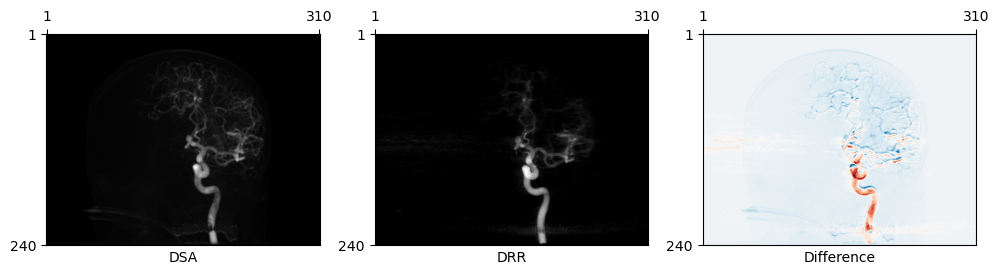

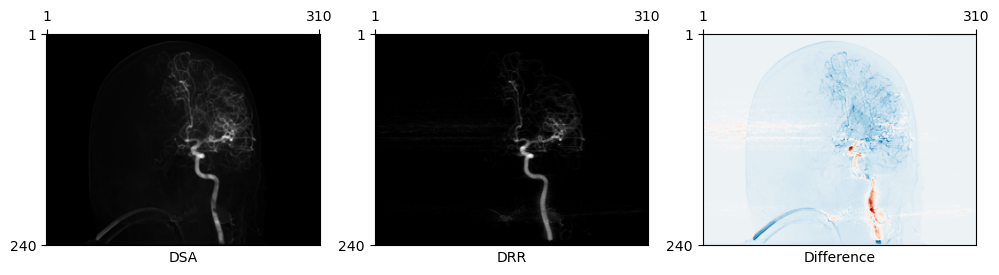

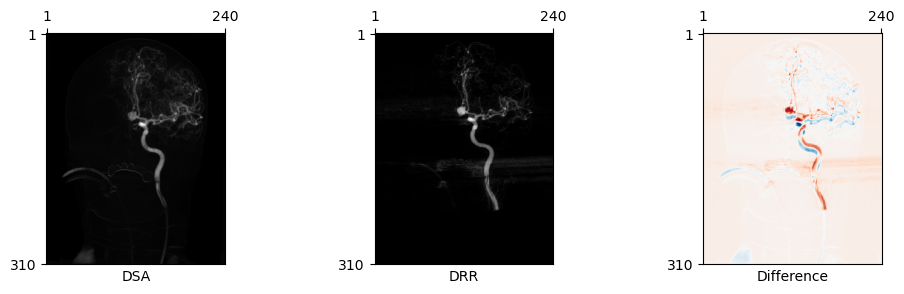

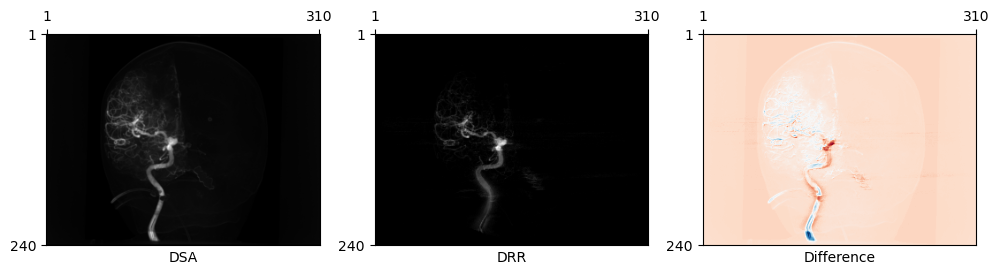

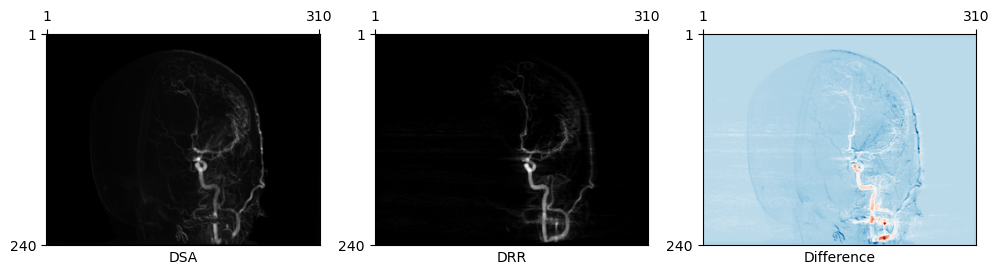

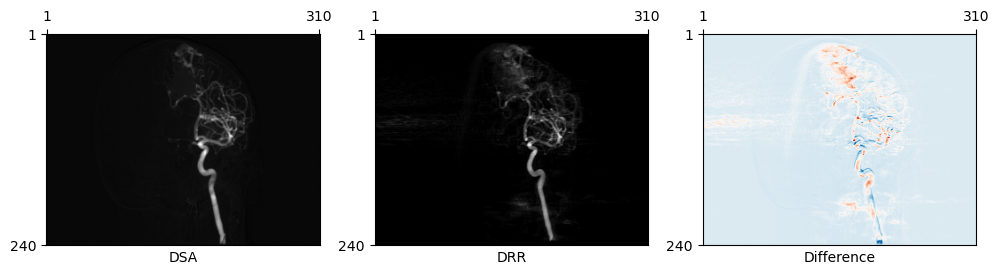

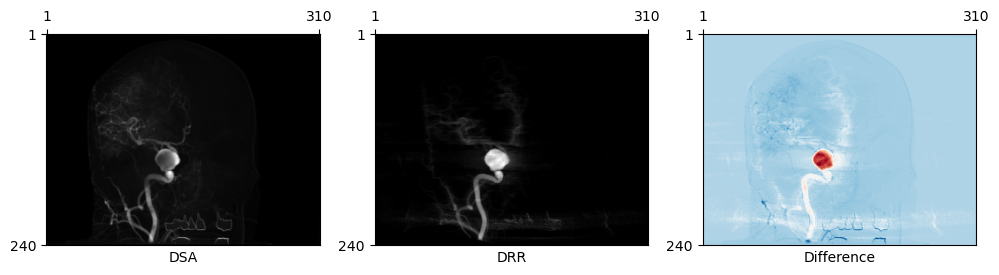

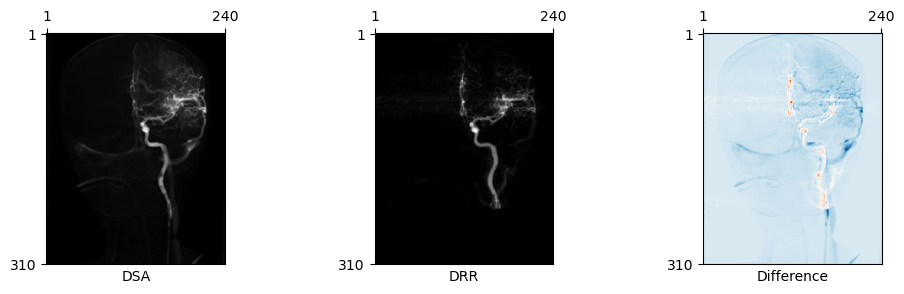

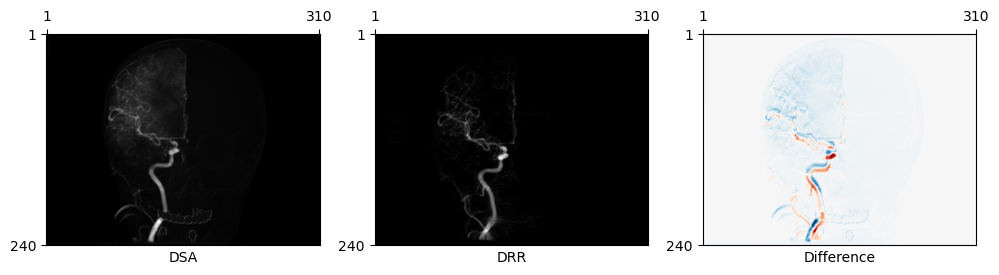

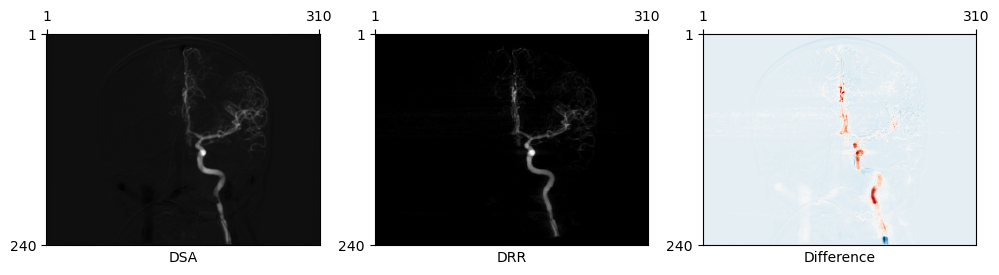

In [ ]:
#| eval: false
subject = LjubljanaDataset(view="ap", filename="../../data/ljubljana.h5")

for idx in range(len(subject)):
    (
        volume,
        spacing,
        focal_len,
        height,
        width,
        delx,
        dely,
        x0,
        y0,
        img,
        pose,
        isocenter_pose,
    ) = subject[idx]
    volume[volume < 500] = 0.0
    if idx == 5:
        volume[volume < 1000] = 0.0

    drr = DRR(
        volume,
        spacing,
        focal_len / 2,
        height // 8,
        delx * 8,
        width // 8,
        dely * 8,
        x0,
        y0,
        reverse_x_axis=True,
    ).cuda()
    transforms = Transforms(height // 8, width // 8)

    img = transforms(img).cuda()
    pred_img = drr(None, None, None, pose=pose.cuda())
    pred_img = transforms(pred_img)

    plt.figure(figsize=(12, 3))
    ax = plt.subplot(131)
    plot_drr(img, axs=ax, title="DSA")
    ax = plt.subplot(132)
    plot_drr(pred_img, axs=ax, title="DRR")
    ax = plt.subplot(133)
    plot_drr(img - pred_img, axs=ax, title="Difference", cmap="RdBu")
    plt.show()

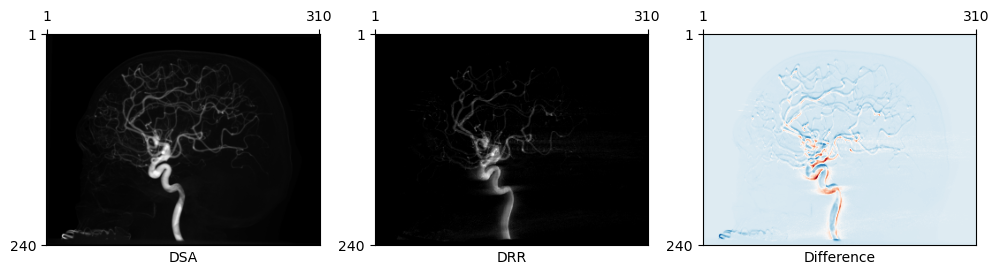

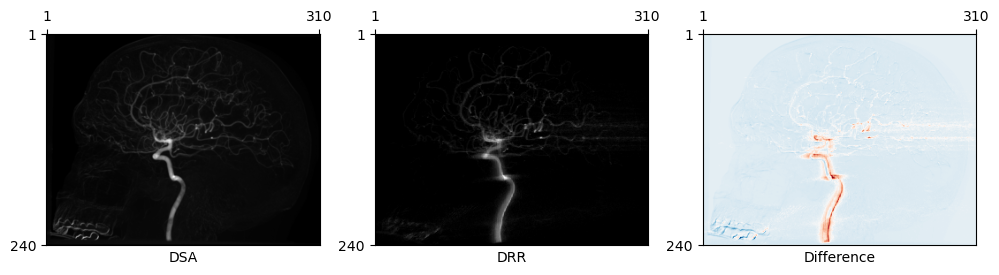

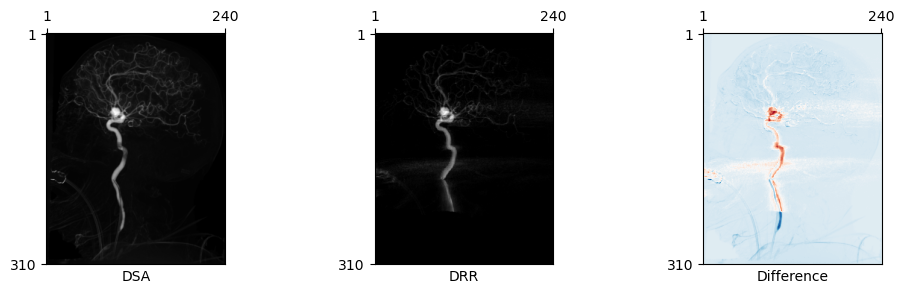

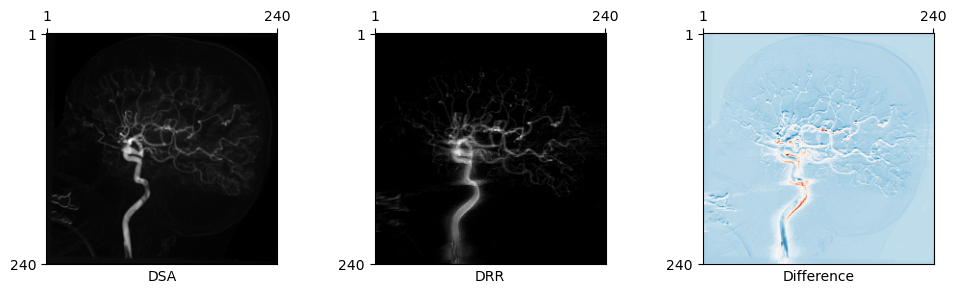

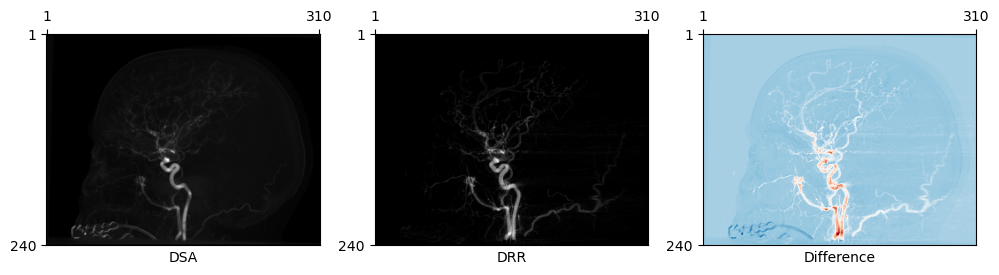

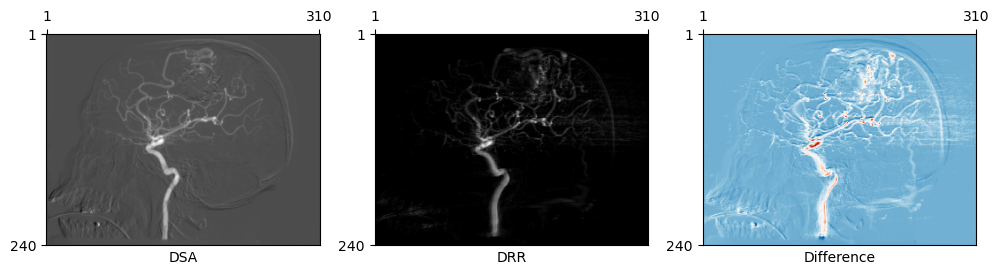

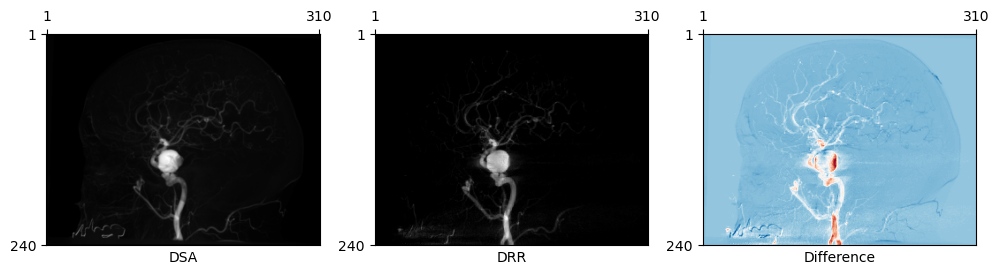

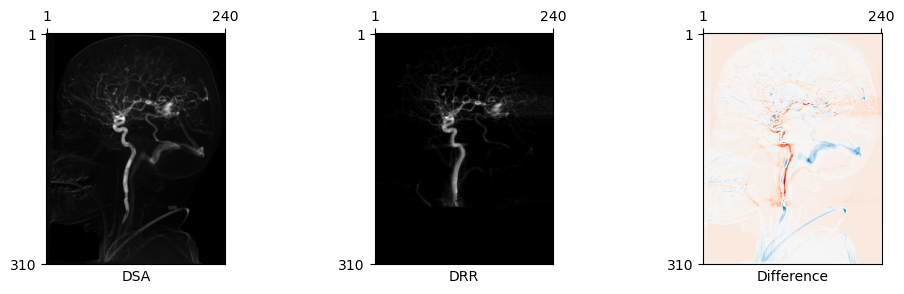

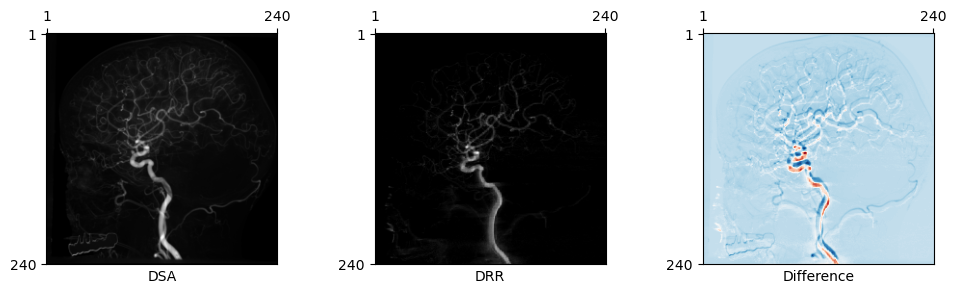

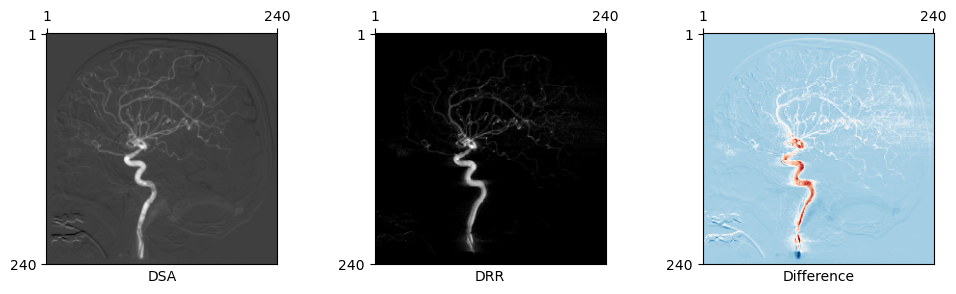

In [ ]:
#| eval: false
subject = LjubljanaDataset(view="lat", filename="../../data/ljubljana.h5")

for idx in range(len(subject)):
    (
        volume,
        spacing,
        focal_len,
        height,
        width,
        delx,
        dely,
        x0,
        y0,
        img,
        pose,
        isocenter_pose,
    ) = subject[idx]
    volume[volume < 500] = 0.0
    if idx == 5:
        volume[volume < 1000] = 0.0

    drr = DRR(
        volume,
        spacing,
        focal_len / 2,
        height // 8,
        delx * 8,
        width // 8,
        dely * 8,
        x0,
        y0,
        reverse_x_axis=True,
    ).cuda()
    transforms = Transforms(height // 8, width // 8)

    img = transforms(img).cuda()
    pred_img = drr(None, None, None, pose=pose.cuda())
    pred_img = transforms(pred_img)

    plt.figure(figsize=(12, 3))
    ax = plt.subplot(131)
    plot_drr(img, axs=ax, title="DSA")
    ax = plt.subplot(132)
    plot_drr(pred_img, axs=ax, title="DRR")
    ax = plt.subplot(133)
    plot_drr(img - pred_img, axs=ax, title="Difference", cmap="RdBu")
    plt.show()

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()